# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 100, 100, 100, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 100, 100, 100, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 0.9752
Epoch 1/200, Iteration 2/12, Loss: 0.6710
Epoch 1/200, Iteration 3/12, Loss: 0.4758
Epoch 1/200, Iteration 4/12, Loss: 0.1103
Epoch 1/200, Iteration 5/12, Loss: 0.3431
Epoch 1/200, Iteration 6/12, Loss: 0.3618
Epoch 1/200, Iteration 7/12, Loss: 0.0981
Epoch 1/200, Iteration 8/12, Loss: 0.1232
Epoch 1/200, Iteration 9/12, Loss: 0.1572
Epoch 1/200, Iteration 10/12, Loss: 0.1724
Epoch 1/200, Iteration 11/12, Loss: 0.1228
Epoch 1/200, Iteration 12/12, Loss: 0.0866
Epoch 1/200, Iteration 13/12, Loss: 0.0537
Train Error: 
 Accuracy: 50.5%, Avg loss: 0.075434, MRE: 0.139007, MAE: 0.028301 

Test Error: 
 Accuracy: 46.5%, Avg loss: 0.068391, MRE: 0.128832, MAE: 0.029215 

Epoch 2/200, Iteration 1/12, Loss: 0.0836
Epoch 2/200, Iteration 2/12, Loss: 0.1011
Epoch 2/200, Iteration 3/12, Loss: 0.0788
Epoch 2/200, Iteration 4/12, Loss: 0.0525
Epoch 2/200, Iteration 5/12, Loss: 0.0372
Epoch 2/200, Iteration 6/12, Loss: 0.0505
Epoch 2/200, Iteration 7/12, Loss

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.003070, MRE: 0.036310, MAE: 0.005849 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002503, MRE: 0.027417, MAE: 0.005616 

Epoch 13/200, Iteration 1/12, Loss: 0.0025
Epoch 13/200, Iteration 2/12, Loss: 0.0026
Epoch 13/200, Iteration 3/12, Loss: 0.0030
Epoch 13/200, Iteration 4/12, Loss: 0.0032
Epoch 13/200, Iteration 5/12, Loss: 0.0017
Epoch 13/200, Iteration 6/12, Loss: 0.0023
Epoch 13/200, Iteration 7/12, Loss: 0.0054
Epoch 13/200, Iteration 8/12, Loss: 0.0043
Epoch 13/200, Iteration 9/12, Loss: 0.0035
Epoch 13/200, Iteration 10/12, Loss: 0.0022
Epoch 13/200, Iteration 11/12, Loss: 0.0047
Epoch 13/200, Iteration 12/12, Loss: 0.0035
Epoch 13/200, Iteration 13/12, Loss: 0.0043
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.002256, MRE: 0.023688, MAE: 0.004939 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002241, MRE: 0.019264, MAE: 0.005171 

Epoch 14/200, Iteration 1/12, Loss: 0.0024
Epoch 14/200, Iteration 2/12, Loss: 0.0043
Epoch 14/200, Iter

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.001033, MRE: 0.017414, MAE: 0.003483 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000927, MRE: 0.014835, MAE: 0.003319 

Epoch 25/200, Iteration 1/12, Loss: 0.0010
Epoch 25/200, Iteration 2/12, Loss: 0.0008
Epoch 25/200, Iteration 3/12, Loss: 0.0012
Epoch 25/200, Iteration 4/12, Loss: 0.0007
Epoch 25/200, Iteration 5/12, Loss: 0.0012
Epoch 25/200, Iteration 6/12, Loss: 0.0005
Epoch 25/200, Iteration 7/12, Loss: 0.0010
Epoch 25/200, Iteration 8/12, Loss: 0.0010
Epoch 25/200, Iteration 9/12, Loss: 0.0010
Epoch 25/200, Iteration 10/12, Loss: 0.0020
Epoch 25/200, Iteration 11/12, Loss: 0.0011
Epoch 25/200, Iteration 12/12, Loss: 0.0017
Epoch 25/200, Iteration 13/12, Loss: 0.0006
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001106, MRE: 0.017969, MAE: 0.003138 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.000920, MRE: 0.015857, MAE: 0.002948 

Epoch 26/200, Iteration 1/12, Loss: 0.0008
Epoch 26/200, Iteration 2/12, Loss: 0.0012
Epoch 26/200, Iter

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000686, MRE: 0.013141, MAE: 0.002378 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000521, MRE: 0.010437, MAE: 0.002213 

Epoch 37/200, Iteration 1/12, Loss: 0.0006
Epoch 37/200, Iteration 2/12, Loss: 0.0007
Epoch 37/200, Iteration 3/12, Loss: 0.0004
Epoch 37/200, Iteration 4/12, Loss: 0.0003
Epoch 37/200, Iteration 5/12, Loss: 0.0006
Epoch 37/200, Iteration 6/12, Loss: 0.0010
Epoch 37/200, Iteration 7/12, Loss: 0.0006
Epoch 37/200, Iteration 8/12, Loss: 0.0005
Epoch 37/200, Iteration 9/12, Loss: 0.0007
Epoch 37/200, Iteration 10/12, Loss: 0.0011
Epoch 37/200, Iteration 11/12, Loss: 0.0004
Epoch 37/200, Iteration 12/12, Loss: 0.0006
Epoch 37/200, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000614, MRE: 0.016415, MAE: 0.002673 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000621, MRE: 0.011886, MAE: 0.002686 

Epoch 38/200, Iteration 1/12, Loss: 0.0007
Epoch 38/200, Iteration 2/12, Loss: 0.0008
Epoch 38/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000101, MRE: 0.005949, MAE: 0.000875 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000109, MRE: 0.004985, MAE: 0.000938 

Epoch 49/200, Iteration 1/12, Loss: 0.0001
Epoch 49/200, Iteration 2/12, Loss: 0.0001
Epoch 49/200, Iteration 3/12, Loss: 0.0001
Epoch 49/200, Iteration 4/12, Loss: 0.0001
Epoch 49/200, Iteration 5/12, Loss: 0.0001
Epoch 49/200, Iteration 6/12, Loss: 0.0001
Epoch 49/200, Iteration 7/12, Loss: 0.0001
Epoch 49/200, Iteration 8/12, Loss: 0.0001
Epoch 49/200, Iteration 9/12, Loss: 0.0001
Epoch 49/200, Iteration 10/12, Loss: 0.0002
Epoch 49/200, Iteration 11/12, Loss: 0.0001
Epoch 49/200, Iteration 12/12, Loss: 0.0001
Epoch 49/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000096, MRE: 0.005880, MAE: 0.000858 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000105, MRE: 0.004888, MAE: 0.000895 

Epoch 50/200, Iteration 1/12, Loss: 0.0001
Epoch 50/200, Iteration 2/12, Loss: 0.0001
Epoch 50/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000082, MRE: 0.005703, MAE: 0.000808 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000090, MRE: 0.004463, MAE: 0.000870 

Epoch 61/200, Iteration 1/12, Loss: 0.0001
Epoch 61/200, Iteration 2/12, Loss: 0.0001
Epoch 61/200, Iteration 3/12, Loss: 0.0001
Epoch 61/200, Iteration 4/12, Loss: 0.0001
Epoch 61/200, Iteration 5/12, Loss: 0.0001
Epoch 61/200, Iteration 6/12, Loss: 0.0001
Epoch 61/200, Iteration 7/12, Loss: 0.0001
Epoch 61/200, Iteration 8/12, Loss: 0.0000
Epoch 61/200, Iteration 9/12, Loss: 0.0001
Epoch 61/200, Iteration 10/12, Loss: 0.0001
Epoch 61/200, Iteration 11/12, Loss: 0.0001
Epoch 61/200, Iteration 12/12, Loss: 0.0001
Epoch 61/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000081, MRE: 0.005707, MAE: 0.000797 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000096, MRE: 0.004521, MAE: 0.000848 

Epoch 62/200, Iteration 1/12, Loss: 0.0001
Epoch 62/200, Iteration 2/12, Loss: 0.0001
Epoch 62/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000070, MRE: 0.005521, MAE: 0.000767 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000082, MRE: 0.004256, MAE: 0.000807 

Epoch 73/200, Iteration 1/12, Loss: 0.0001
Epoch 73/200, Iteration 2/12, Loss: 0.0001
Epoch 73/200, Iteration 3/12, Loss: 0.0000
Epoch 73/200, Iteration 4/12, Loss: 0.0000
Epoch 73/200, Iteration 5/12, Loss: 0.0001
Epoch 73/200, Iteration 6/12, Loss: 0.0001
Epoch 73/200, Iteration 7/12, Loss: 0.0001
Epoch 73/200, Iteration 8/12, Loss: 0.0001
Epoch 73/200, Iteration 9/12, Loss: 0.0001
Epoch 73/200, Iteration 10/12, Loss: 0.0000
Epoch 73/200, Iteration 11/12, Loss: 0.0001
Epoch 73/200, Iteration 12/12, Loss: 0.0001
Epoch 73/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000074, MRE: 0.005578, MAE: 0.000763 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000078, MRE: 0.004109, MAE: 0.000790 

Epoch 74/200, Iteration 1/12, Loss: 0.0001
Epoch 74/200, Iteration 2/12, Loss: 0.0001
Epoch 74/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000066, MRE: 0.005379, MAE: 0.000722 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000077, MRE: 0.004056, MAE: 0.000768 

Epoch 85/200, Iteration 1/12, Loss: 0.0000
Epoch 85/200, Iteration 2/12, Loss: 0.0001
Epoch 85/200, Iteration 3/12, Loss: 0.0001
Epoch 85/200, Iteration 4/12, Loss: 0.0001
Epoch 85/200, Iteration 5/12, Loss: 0.0001
Epoch 85/200, Iteration 6/12, Loss: 0.0000
Epoch 85/200, Iteration 7/12, Loss: 0.0001
Epoch 85/200, Iteration 8/12, Loss: 0.0001
Epoch 85/200, Iteration 9/12, Loss: 0.0001
Epoch 85/200, Iteration 10/12, Loss: 0.0001
Epoch 85/200, Iteration 11/12, Loss: 0.0000
Epoch 85/200, Iteration 12/12, Loss: 0.0001
Epoch 85/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000059, MRE: 0.005223, MAE: 0.000682 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000075, MRE: 0.004077, MAE: 0.000744 

Epoch 86/200, Iteration 1/12, Loss: 0.0001
Epoch 86/200, Iteration 2/12, Loss: 0.0001
Epoch 86/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000056, MRE: 0.005106, MAE: 0.000659 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000071, MRE: 0.004001, MAE: 0.000711 

Epoch 97/200, Iteration 1/12, Loss: 0.0000
Epoch 97/200, Iteration 2/12, Loss: 0.0001
Epoch 97/200, Iteration 3/12, Loss: 0.0001
Epoch 97/200, Iteration 4/12, Loss: 0.0000
Epoch 97/200, Iteration 5/12, Loss: 0.0001
Epoch 97/200, Iteration 6/12, Loss: 0.0000
Epoch 97/200, Iteration 7/12, Loss: 0.0000
Epoch 97/200, Iteration 8/12, Loss: 0.0001
Epoch 97/200, Iteration 9/12, Loss: 0.0000
Epoch 97/200, Iteration 10/12, Loss: 0.0001
Epoch 97/200, Iteration 11/12, Loss: 0.0001
Epoch 97/200, Iteration 12/12, Loss: 0.0000
Epoch 97/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000054, MRE: 0.005088, MAE: 0.000650 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000071, MRE: 0.003857, MAE: 0.000708 

Epoch 98/200, Iteration 1/12, Loss: 0.0000
Epoch 98/200, Iteration 2/12, Loss: 0.0001
Epoch 98/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000067, MRE: 0.005496, MAE: 0.000749 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000087, MRE: 0.004427, MAE: 0.000823 

Epoch 109/200, Iteration 1/12, Loss: 0.0001
Epoch 109/200, Iteration 2/12, Loss: 0.0001
Epoch 109/200, Iteration 3/12, Loss: 0.0001
Epoch 109/200, Iteration 4/12, Loss: 0.0000
Epoch 109/200, Iteration 5/12, Loss: 0.0001
Epoch 109/200, Iteration 6/12, Loss: 0.0001
Epoch 109/200, Iteration 7/12, Loss: 0.0001
Epoch 109/200, Iteration 8/12, Loss: 0.0001
Epoch 109/200, Iteration 9/12, Loss: 0.0001
Epoch 109/200, Iteration 10/12, Loss: 0.0001
Epoch 109/200, Iteration 11/12, Loss: 0.0001
Epoch 109/200, Iteration 12/12, Loss: 0.0001
Epoch 109/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000057, MRE: 0.005136, MAE: 0.000689 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000077, MRE: 0.004103, MAE: 0.000759 

Epoch 110/200, Iteration 1/12, Loss: 0.0000
Epoch 110/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000048, MRE: 0.004887, MAE: 0.000623 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000059, MRE: 0.003608, MAE: 0.000651 

Epoch 121/200, Iteration 1/12, Loss: 0.0000
Epoch 121/200, Iteration 2/12, Loss: 0.0001
Epoch 121/200, Iteration 3/12, Loss: 0.0000
Epoch 121/200, Iteration 4/12, Loss: 0.0001
Epoch 121/200, Iteration 5/12, Loss: 0.0001
Epoch 121/200, Iteration 6/12, Loss: 0.0001
Epoch 121/200, Iteration 7/12, Loss: 0.0000
Epoch 121/200, Iteration 8/12, Loss: 0.0000
Epoch 121/200, Iteration 9/12, Loss: 0.0000
Epoch 121/200, Iteration 10/12, Loss: 0.0001
Epoch 121/200, Iteration 11/12, Loss: 0.0000
Epoch 121/200, Iteration 12/12, Loss: 0.0001
Epoch 121/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000050, MRE: 0.005273, MAE: 0.000658 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000064, MRE: 0.003745, MAE: 0.000674 

Epoch 122/200, Iteration 1/12, Loss: 0.0001
Epoch 122/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000039, MRE: 0.004528, MAE: 0.000547 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000051, MRE: 0.003322, MAE: 0.000594 

Epoch 133/200, Iteration 1/12, Loss: 0.0000
Epoch 133/200, Iteration 2/12, Loss: 0.0000
Epoch 133/200, Iteration 3/12, Loss: 0.0000
Epoch 133/200, Iteration 4/12, Loss: 0.0000
Epoch 133/200, Iteration 5/12, Loss: 0.0000
Epoch 133/200, Iteration 6/12, Loss: 0.0000
Epoch 133/200, Iteration 7/12, Loss: 0.0000
Epoch 133/200, Iteration 8/12, Loss: 0.0000
Epoch 133/200, Iteration 9/12, Loss: 0.0001
Epoch 133/200, Iteration 10/12, Loss: 0.0000
Epoch 133/200, Iteration 11/12, Loss: 0.0000
Epoch 133/200, Iteration 12/12, Loss: 0.0000
Epoch 133/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000039, MRE: 0.004537, MAE: 0.000545 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000051, MRE: 0.003326, MAE: 0.000592 

Epoch 134/200, Iteration 1/12, Loss: 0.0000
Epoch 134/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000039, MRE: 0.004524, MAE: 0.000543 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000051, MRE: 0.003295, MAE: 0.000594 

Epoch 145/200, Iteration 1/12, Loss: 0.0000
Epoch 145/200, Iteration 2/12, Loss: 0.0000
Epoch 145/200, Iteration 3/12, Loss: 0.0000
Epoch 145/200, Iteration 4/12, Loss: 0.0000
Epoch 145/200, Iteration 5/12, Loss: 0.0001
Epoch 145/200, Iteration 6/12, Loss: 0.0001
Epoch 145/200, Iteration 7/12, Loss: 0.0000
Epoch 145/200, Iteration 8/12, Loss: 0.0000
Epoch 145/200, Iteration 9/12, Loss: 0.0000
Epoch 145/200, Iteration 10/12, Loss: 0.0000
Epoch 145/200, Iteration 11/12, Loss: 0.0000
Epoch 145/200, Iteration 12/12, Loss: 0.0000
Epoch 145/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000040, MRE: 0.004590, MAE: 0.000550 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000049, MRE: 0.003272, MAE: 0.000587 

Epoch 146/200, Iteration 1/12, Loss: 0.0001
Epoch 146/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000038, MRE: 0.004496, MAE: 0.000536 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000050, MRE: 0.003300, MAE: 0.000593 

Epoch 157/200, Iteration 1/12, Loss: 0.0000
Epoch 157/200, Iteration 2/12, Loss: 0.0000
Epoch 157/200, Iteration 3/12, Loss: 0.0000
Epoch 157/200, Iteration 4/12, Loss: 0.0000
Epoch 157/200, Iteration 5/12, Loss: 0.0000
Epoch 157/200, Iteration 6/12, Loss: 0.0000
Epoch 157/200, Iteration 7/12, Loss: 0.0000
Epoch 157/200, Iteration 8/12, Loss: 0.0001
Epoch 157/200, Iteration 9/12, Loss: 0.0000
Epoch 157/200, Iteration 10/12, Loss: 0.0000
Epoch 157/200, Iteration 11/12, Loss: 0.0000
Epoch 157/200, Iteration 12/12, Loss: 0.0000
Epoch 157/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000038, MRE: 0.004503, MAE: 0.000539 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000049, MRE: 0.003276, MAE: 0.000586 

Epoch 158/200, Iteration 1/12, Loss: 0.0000
Epoch 158/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000037, MRE: 0.004478, MAE: 0.000534 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000048, MRE: 0.003240, MAE: 0.000581 

Epoch 169/200, Iteration 1/12, Loss: 0.0000
Epoch 169/200, Iteration 2/12, Loss: 0.0000
Epoch 169/200, Iteration 3/12, Loss: 0.0000
Epoch 169/200, Iteration 4/12, Loss: 0.0000
Epoch 169/200, Iteration 5/12, Loss: 0.0001
Epoch 169/200, Iteration 6/12, Loss: 0.0001
Epoch 169/200, Iteration 7/12, Loss: 0.0000
Epoch 169/200, Iteration 8/12, Loss: 0.0000
Epoch 169/200, Iteration 9/12, Loss: 0.0000
Epoch 169/200, Iteration 10/12, Loss: 0.0001
Epoch 169/200, Iteration 11/12, Loss: 0.0000
Epoch 169/200, Iteration 12/12, Loss: 0.0000
Epoch 169/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000037, MRE: 0.004461, MAE: 0.000531 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000049, MRE: 0.003258, MAE: 0.000584 

Epoch 170/200, Iteration 1/12, Loss: 0.0000
Epoch 170/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000037, MRE: 0.004466, MAE: 0.000533 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000049, MRE: 0.003236, MAE: 0.000583 

Epoch 181/200, Iteration 1/12, Loss: 0.0000
Epoch 181/200, Iteration 2/12, Loss: 0.0000
Epoch 181/200, Iteration 3/12, Loss: 0.0001
Epoch 181/200, Iteration 4/12, Loss: 0.0000
Epoch 181/200, Iteration 5/12, Loss: 0.0000
Epoch 181/200, Iteration 6/12, Loss: 0.0000
Epoch 181/200, Iteration 7/12, Loss: 0.0001
Epoch 181/200, Iteration 8/12, Loss: 0.0000
Epoch 181/200, Iteration 9/12, Loss: 0.0001
Epoch 181/200, Iteration 10/12, Loss: 0.0000
Epoch 181/200, Iteration 11/12, Loss: 0.0000
Epoch 181/200, Iteration 12/12, Loss: 0.0000
Epoch 181/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000037, MRE: 0.004487, MAE: 0.000531 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000048, MRE: 0.003216, MAE: 0.000579 

Epoch 182/200, Iteration 1/12, Loss: 0.0000
Epoch 182/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000037, MRE: 0.004418, MAE: 0.000527 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000049, MRE: 0.003215, MAE: 0.000581 

Epoch 193/200, Iteration 1/12, Loss: 0.0000
Epoch 193/200, Iteration 2/12, Loss: 0.0001
Epoch 193/200, Iteration 3/12, Loss: 0.0001
Epoch 193/200, Iteration 4/12, Loss: 0.0001
Epoch 193/200, Iteration 5/12, Loss: 0.0000
Epoch 193/200, Iteration 6/12, Loss: 0.0000
Epoch 193/200, Iteration 7/12, Loss: 0.0000
Epoch 193/200, Iteration 8/12, Loss: 0.0000
Epoch 193/200, Iteration 9/12, Loss: 0.0000
Epoch 193/200, Iteration 10/12, Loss: 0.0000
Epoch 193/200, Iteration 11/12, Loss: 0.0000
Epoch 193/200, Iteration 12/12, Loss: 0.0000
Epoch 193/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000036, MRE: 0.004409, MAE: 0.000525 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000047, MRE: 0.003199, MAE: 0.000573 

Epoch 194/200, Iteration 1/12, Loss: 0.0000
Epoch 194/200, Iteration 2/12, Loss: 0.0000
Ep

#### Plots loss vs Epoch

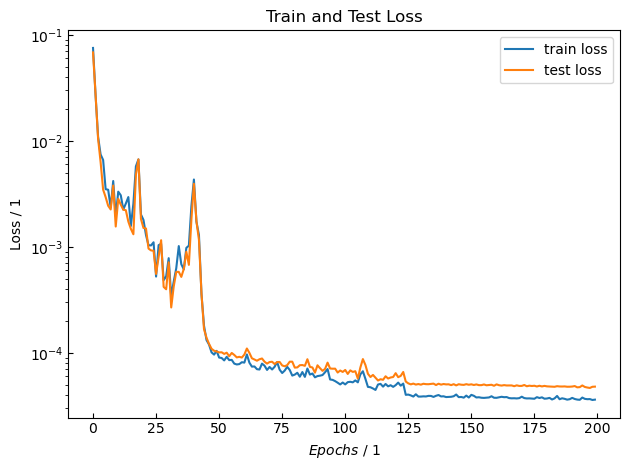

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.999973429976446 , R^2(NH3) = 0.9999530383276626
Test Dataset: R^2(H2) = 0.9999651266334264 , R^2(NH3) = 0.9999431519885154
Max Error Training: |x_H2 - x_H2,pred| = 0.008925284446020754 , |x_NH3 - x_NH3,pred| = 0.003553015939278481
Max Error Test: |x_H2 - x_H2,pred| = 0.006525246967990228 , |x_NH3 - x_NH3,pred| = 0.004737595223085436


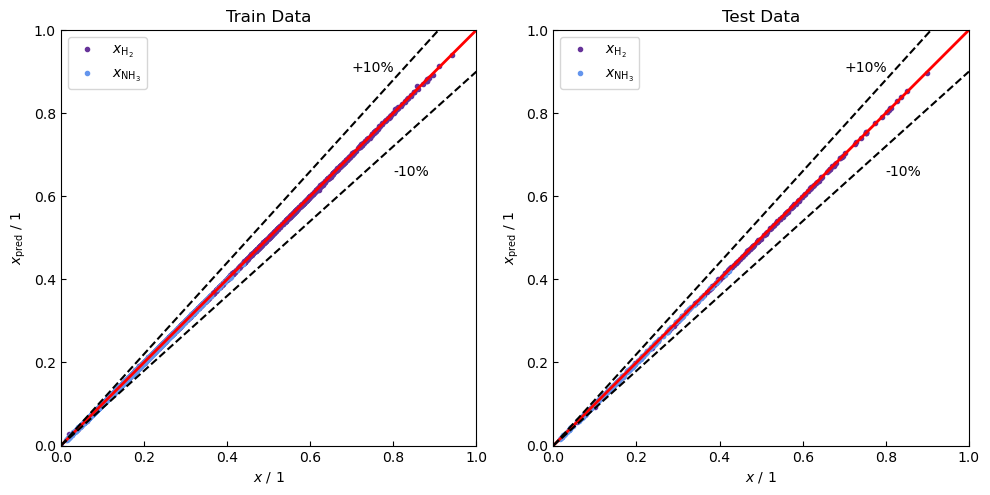

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

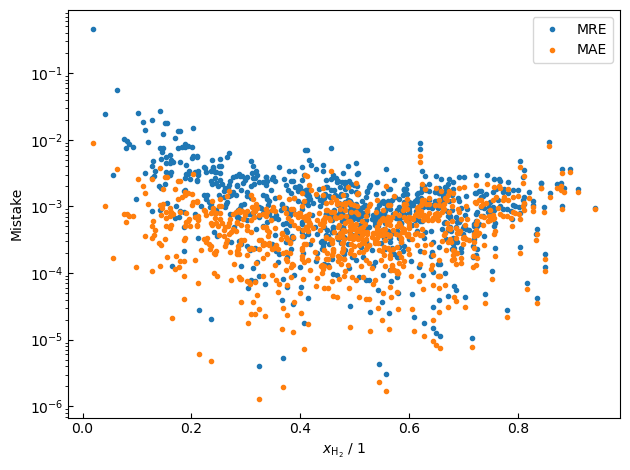

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

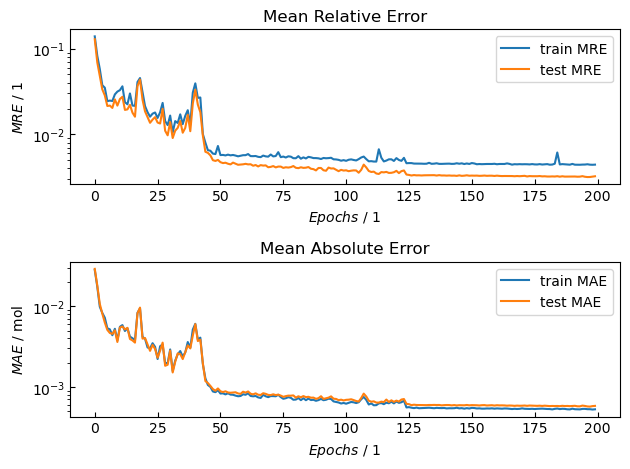

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

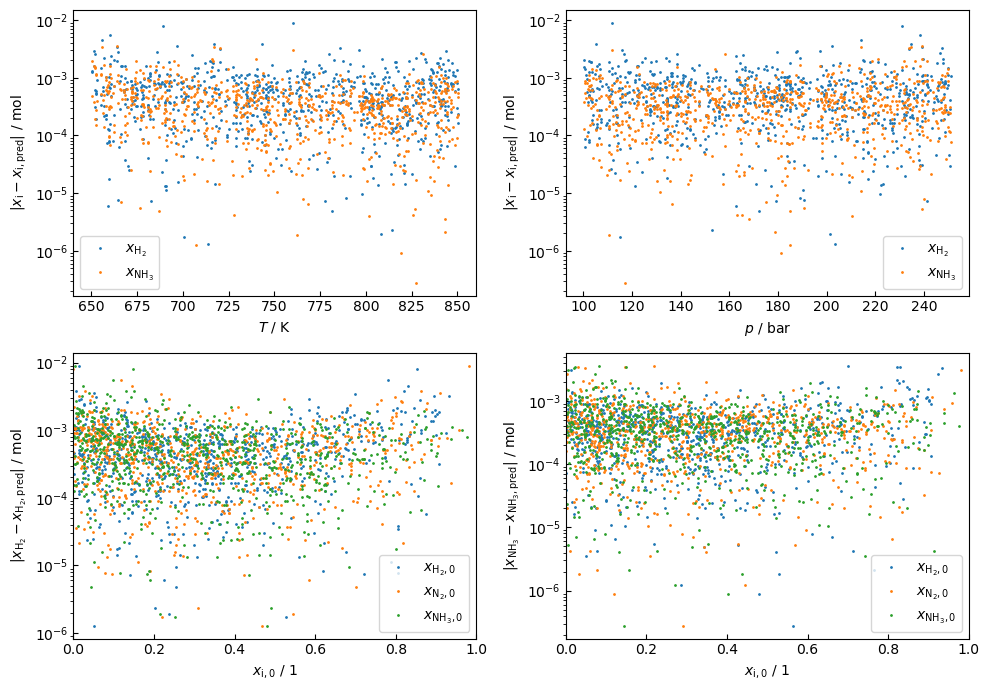

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

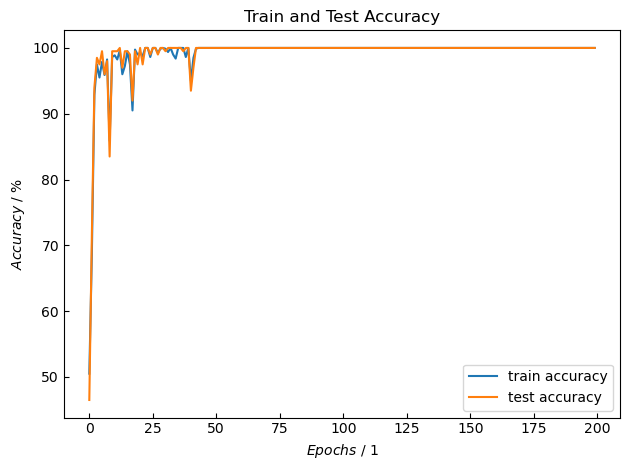

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.0625 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.1546e+00, -1.0749e+00,  1.0006e+00,  2.3159e-01, -1.2187e+00],
        [-6.3324e-01,  3.4146e-01, -5.1085e-01,  6.8952e-01, -2.0341e-01],
        [ 8.8372e-01,  1.0953e+00,  4.3870e-02, -1.2372e+00,  1.2215e+00],
        [-1.6303e+00, -8.9618e-01, -5.8100e-01,  1.2246e+00, -6.8142e-01],
        [-3.6024e-01, -1.7744e-01,  7.2088e-01, -1.2337e+00,  5.5348e-01],
        [ 1.1662e-01, -8.4935e-01, -3.6919e-01,  1.6880e+00, -1.3630e+00],
        [-1.7457e+00,  1.6628e+00, -4.5099e-02,  3.5279e-01, -3.1632e-01],
        [-1.4725e-01,  3.5406e-03,  7.8259e-01,  4.9823e-01, -1.2772e+00],
        [-7.4248e-01, -1.0883e+00,  6.1900e-02,  7.9642e-01, -8.7475e-01],
        [ 1.1188e+00, -3.4159e-01,  3.8753e-01, -1.1822e+00,  8.2796e-01],
        [ 2.3532e-01, -2.7843e-01, -5.9243e-01,  9.0409e-01, -3.4264e-01],
        [-1.4215e+00, -1.3630e+00,  2.8609e-01, -1.2044e+00,  9.5021e-01],
        [-8.1115e-01, -9.4013e-01,  6.9493e-01, -6.0763e-01, -6.0950e-02],
        [ 1.5271e-01,  5.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-2.3171e-02, -9.3766e-02, -3.0105e-01,  2.5303e-01, -4.3935e-01],
         [-2.7028e-01,  1.0213e-01,  4.2963e-01, -2.4536e-01,  4.0436e-01],
         [ 6.2826e-02,  5.1139e-02, -3.5720e-01,  2.6118e-01,  5.4382e-02],
         [ 4.2684e-01,  1.4644e-01, -9.1071e-02, -1.2465e-01,  3.4057e-01],
         [ 4.1069e-01, -2.5432e-01, -2.3177e-01, -1.7744e-01, -3.7799e-01],
         [ 1.8949e-01, -3.7464e-01,  5.3957e-02, -6.5683e-02,  2.5986e-01],
         [ 2.6140e-01, -4.0731e-01,  2.9925e-01,  3.5697e-01,  8.9689e-02],
         [ 6.1515e-02, -2.8787e-01,  3.7840e-01, -5.1995e-01,  2.4240e-01],
         [-4.8418e-03,  5.8494e-02,  7.9556e-02,  4.3531e-01, -6.5549e-02],
         [-4.0602e-01,  3.2666e-01, -1.7795e-01,  7.6615e-02, -2.9207e-02],
         [ 3.5193e-01,  1.8498e-02, -2.6255e-01, -5.5467e-01, -3.2993e-01],
         [-2.1225e-01,  4.1712e-02,  3.9153e-01,  1.2560e-01,  1.6474e-01],
         [ 2.9936e-01,  9.1177e-02,  2.9819e-01, -7.9929e-03, -1.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.2592, 0.7978, 0.5414, 0.0867, 0.8102],
        [0.2221, 0.2637, 0.4780, 0.3585, 0.4986]])
tensor([[0.2966, 0.4617],
        [0.1120, 0.2450]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-2.4932e-01,  7.4298e-01,  3.5740e-01,  4.6301e-02, -3.9807e-01],
        [ 1.4179e+00,  1.6501e+00,  1.4858e+00, -1.1919e+00, -2.3998e-01],
        [-9.3820e-01,  1.9071e-01,  4.2470e-01, -6.1213e-01,  2.0885e-01],
        [ 1.3108e+00,  6.2988e-01,  1.2637e-01,  3.6792e-01, -5.0006e-01],
        [-1.0963e+00,  1.4259e+00, -4.2807e-01, -3.2783e-01,  7.5517e-01],
        [-9.4713e-01,  1.8962e-02, -1.0980e+00, -1.2709e+00,  2.3764e+00],
        [ 9.1161e-01, -3.6683e-01,  6.0314e-02, -1.8765e-01,  1.3260e-01],
        [-9.8570e-01,  7.6694e-01,  1.4802e+00, -3.4036e-01, -1.1048e+00],
        [ 3.8197e-01, -1.4799e+00, -8.6255e-01,  1.6130e+00, -8.0214e-01],
        [-2.4813e-01,  1.0058e+00, -6.1781e-01, -1.2717e+00,  1.9061e+00],
        [-4.6709e-01, -2.8390e-01, -1.1062e+00, -1.3442e+00,  2.4594e+00],
        [ 1.2618e+00, -7.6549e-01, -9.3106e-02,  4.3914e-01, -3.5746e-01],
        [-3.3035e-02,  1.4305e+00,  1.1346e+00, -1.0675e+00, -2.2423e-02],
        [-6.0781e-01, -1.

#### Histogramme Verteilung von $xi$ und $x{_i}$

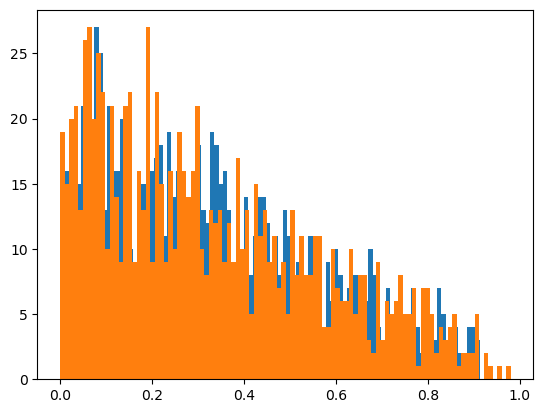

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_027.pth')
# np.savez('data/models/params_005_027.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)